# Twitter Sentiment Pipeline Introduction

This project explores Natural Language Processing (NLP) techniques to analyze and classify the emotional tone and sentiment, expressed in social media text data in tweets from X (formerly Twitter). Using a combination of real-time data retrieval and supervised learning, we aim to build models that can accurately predict sentiment as positive or negative.

We use the Sentiment140 dataset, accessed via Hugging Face Datasets, as our training and evaluation foundation. This dataset provides a large corpus of pre-labeled tweets, making it ideal for benchmarking model performance. Real-time tweets are fetched using the Tweepy library and authenticated access to the Twitter API.

The main objective is to evaluate multiple machine learning classifiers such as Logistic Regression, Random Forest, and others-to determine which model performs best on the sentiment classification task.

## Data Pre-processing

First, we will import the nessecary libraries used for the entire project. We will evaluate and reduce the dimensions of the imported data (via Hugging Face datasets).  

In [1]:
# Required imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

import datasets
from twitter_pipeline import TwitterClient, TweetAnalyzer

c:\Users\Joey\.conda\envs\twitter-sentiment\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Load Training Data for models ###

# Load Sentiment140 directly from Hugging Face datasets
dataset = datasets.load_dataset("sentiment140", trust_remote_code=True)

df = dataset["train"]

print(df[0])

{'text': "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", 'date': 'Mon Apr 06 22:19:45 PDT 2009', 'user': '_TheSpecialOne_', 'sentiment': 0, 'query': 'NO_QUERY'}


In [3]:
# Convert to pandas DataFrame for easier manipulation
df = df.to_pandas()

# Label Encoding, sentiment column binary classification
df['label'] = df['sentiment'].replace({0: 0, 4: 1})

df.head()

,text,date,user,sentiment,query,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,0,NO_QUERY,0
1,is upset that he can't update his Facebook by ...,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,0,NO_QUERY,0
2,@Kenichan I dived many times for the ball. Man...,Mon Apr 06 22:19:53 PDT 2009,mattycus,0,NO_QUERY,0
3,my whole body feels itchy and like its on fire,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,0,NO_QUERY,0
4,"@nationwideclass no, it's not behaving at all....",Mon Apr 06 22:19:57 PDT 2009,Karoli,0,NO_QUERY,0


In [4]:
# Preprocess text data using lemmatization

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # remove mentions and hashtags
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Joey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Distinguish predictors and target variable
X_ = df['clean_text']
y_ = df['label']

print(X_.shape, y_.shape)
print(X_[0])
print(y_[0])
print(y_.unique())

(1600000,) (1600000,)
thats bummer shoulda got david carr third day
0
[0 1]


In [6]:
'''
Expand predictors into vectorized features

We are choosing to use TF-IDF vectorization for the text data.
With TF-IDF, we want to capture word importance across documents, 
    rather than simplly using word counts (using CountVectorizer).

**Alternative Options: Word2Vec & GloVe's Twitter Embeddings (glove_url = "http://nlp.stanford.edu/data/glove.twitter.27B.zip")**
'''

X_train, X_test, y_train, y_test = train_test_split(X_, y_, 
                                                            test_size=0.2, 
                                                            random_state=0)

# Initialize the vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

# Fit & transform training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform test data
X_test_tfidf = vectorizer.transform(X_test)

In [7]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

print(feature_names[:20])
print(X_train_tfidf.shape)

['aa' 'aaa' 'aaaa' 'aaaah' 'aaaand' 'aaah' 'aaahhh' 'aaaw' 'aah' 'aahh'
 'aahhh' 'aargh' 'aaron' 'aaw' 'aaww' 'ab' 'abandoned' 'abbey' 'abby'
 'abc']
(1280000, 10000)


In [8]:
### Inspect Vectorized Content ####

# Convert first tweet to dense and get non-zero values
vector_0 = X_train_tfidf[0].toarray()[0]

# Get non-zero features and their scores
for idx, score in enumerate(vector_0):
    if score > 0:
        print(f"{feature_names[idx]}: {score}")

like: 0.3375342793323487
pic: 0.5074987051768404
thx: 0.6219441375031388
ur: 0.4916311262978569


## Data Exploration

Check for imbalance and visualize data. 

In [9]:
# Check class distribution
y_train.value_counts()

label
0    640185
1    639815
Name: count, dtype: int64

In [10]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
text          0
date          0
user          0
sentiment     0
query         0
label         0
clean_text    0
dtype: int64


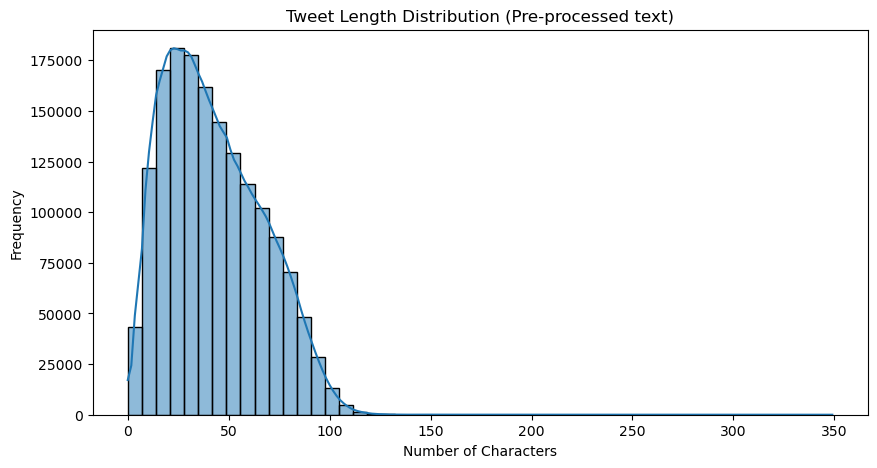

In [11]:
df['text_length'] = df['clean_text'].apply(len)

plt.figure(figsize=(10,5))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Tweet Length Distribution (Pre-processed text)")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

## Machine Learning Models

The 3 models we will be evaluating are the Logisitic Regression, Multinomial Naive Bayes, and Support Vector Machine (SVM) models. These models have been chosen for their efficient performance with large datasets and their unique discriminative and probabiilistic approaches. The F1-score and accuracy are the primary performance metric we'll be comparing and improving across each of the machine learning models.

### Logistic Regression

In [12]:
LR = LogisticRegression(max_iter=1000, random_state=0)

param_grid = {'C': [0.1, 1, 10],
              'solver': ['sag', 'saga']
              }

grid_search = GridSearchCV(estimator=LR,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train_tfidf, y_train)

best_LR = grid_search.best_estimator_

In [13]:
y_hat = best_LR.predict(X_test_tfidf)

# Compute Performance metrics
conf_matrix = confusion_matrix(y_test, y_hat)

print("Best Params:", grid_search.best_params_)
print(conf_matrix)
print(classification_report(y_test, y_hat))

Best Params: {'C': 1, 'solver': 'saga'}
[[119177  40638]
 [ 32602 127583]]
              precision    recall  f1-score   support

           0       0.79      0.75      0.76    159815
           1       0.76      0.80      0.78    160185

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



### Multinomial Naive Bayes

In [14]:
# Apply Multinomial Naive Bayes Classifier
nb = MultinomialNB()

param_grid = {'alpha': [4.0, 5.0, 6.0],
              'fit_prior': [True, False],
              'class_prior': [None, [0.5, 0.5], [0.7, 0.3]]
              }

grid_search = GridSearchCV(estimator=nb,
                           param_grid=param_grid,
                           cv=3,
                           scoring='f1',
                           n_jobs=-1,
                           verbose=1)

# Fit on training data
grid_search.fit(X_train_tfidf, y_train)

best_NB = grid_search.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [15]:
y_hat = best_NB.predict(X_test_tfidf)

# Compute Performance metrics
conf_matrix = confusion_matrix(y_test, y_hat)

print("Best Params:", grid_search.best_params_)
print(conf_matrix)
print(classification_report(y_test, y_hat))

Best Params: {'alpha': 6.0, 'class_prior': None, 'fit_prior': False}
[[121708  38107]
 [ 39223 120962]]
              precision    recall  f1-score   support

           0       0.76      0.76      0.76    159815
           1       0.76      0.76      0.76    160185

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



### Linear Support Vector Machine (SVM)

In [16]:
svm = LinearSVC(random_state=0)
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.1, 1, 10],
              'max_iter': [1000, 2000],
              'dual': [False]
              }

grid_search = GridSearchCV(estimator=svm,
                           param_grid=param_grid,
                           cv=3,
                           scoring='f1',
                           n_jobs=-1,
                           verbose=1)

# Fit on training data
grid_search.fit(X_train_tfidf, y_train)

best_SVM = grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [17]:
y_hat = best_SVM.predict(X_test_tfidf)

# Compute Performance metrics
conf_matrix = confusion_matrix(y_test, y_hat)

print("Best Params:", grid_search.best_params_)
print(conf_matrix)
print(classification_report(y_test, y_hat))

Best Params: {'C': 0.1, 'dual': False, 'max_iter': 1000, 'penalty': 'l1'}
[[117616  42199]
 [ 31364 128821]]
              precision    recall  f1-score   support

           0       0.79      0.74      0.76    159815
           1       0.75      0.80      0.78    160185

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



### Conclusion of Machine Learning Models

We began by pre-processing the data to remove noise from the tweets, such as URLs, hashtags, and other non-informative elements. Then, we applied TF-IDF vectorrization, producing sparse matrices for creating raw text into numerical features, thus capturing the importance of words within individual tweets relative to the corpus. Lastly, this cleaned & vectorized data is used to train the models, yielding F1 scores: 

- Logisitic Regression: 78%
- Multinomial Naive Bayes: 76%
- Support Vector Model: 78%

Based on the confusion matrices, the Logisitic Regression model demonstrated the best balanced and reliable performance. 

## Twitter Live Feed Integration (Twitter API and Machine Learning Model)

We will use the Logisitic Regression Classifier to integrate into the Twitter API. 

In [18]:
'''
Twitter API Client (Get Tweets)
- Get tweets from Twitter API by running 'twitter_pipeline.py' module
- After properly authenticating, we get the tweets and they are stored in 'tweets_output.txt'
'''

streamed_tweets = pd.read_csv("tweets_output.txt", sep="\t")
print(streamed_tweets.head())

                                              tweets  author_id  \
0  "Welcome to the first meeting of the White Hou...        NaN   
1  🇺🇸 Steve Witkoff @SE_MiddleEast has officially...        NaN   
2  RT @VP: The Evening Parade is a longstanding t...        NaN   
3  "Our country is blessed to have a negotiator o...        NaN   
4  RT @MarkJCarney: Thank you to President Trump ...        NaN   

                    id  length  created_at  source  geo  attachments  
0  1919923837195485198     261         NaN     NaN  NaN          NaN  
1  1919923718202998916     158         NaN     NaN  NaN          NaN  
2  1919920715463045325     140         NaN     NaN  NaN          NaN  
3  1919904093071389060     300         NaN     NaN  NaN          NaN  
4  1919877881880060350     140         NaN     NaN  NaN          NaN  


In [19]:
streamed_tweets['tweets'] = streamed_tweets['tweets'].apply(preprocess_text)
X_streamed = streamed_tweets['tweets']
X_streamed_tfidf = vectorizer.transform(X_streamed)
print(X_streamed_tfidf.shape)

# Predict sentiment of streamed tweets 
y_streamed_hat = best_LR.predict(X_streamed_tfidf)
print(y_streamed_hat)
streamed_tweets['predicted_label'] = y_streamed_hat

(15, 10000)
[1 1 1 1 1 1 0 1 1 1 1 0 0 1 1]


In [20]:
print("Positive Sentiment Tweets:")
print(streamed_tweets.loc[streamed_tweets['predicted_label'] == 1, 'tweets'])
print("\nNegative Sentiment Tweets:")
print(streamed_tweets.loc[streamed_tweets['predicted_label'] == 0, 'tweets'])

Positive Sentiment Tweets:
0     welcome first meeting white house fifa task fo...
1     🇺🇸 steve witkoff officially sworn oval office ...
2     rt evening parade longstanding tradition marin...
3     country blessed negotiator skill experience re...
4     rt thank president trump inviting white house ...
5     great honor prime minister u day ago big elect...
7     rt don’t need energy transition need energy ad...
8                                    rt energy price 🇺🇸
9     rt thanks hardworking partner canceling wastef...
10    rt message clear dhs enforce law put safety am...
13    rt 🏆 award show like 📸 scene smallbusinessweek...
14    president trump vance fifa president gianni in...
Name: tweets, dtype: object

Negative Sentiment Tweets:
6     rt sgt brian lieberman ran toward gunfire save...
11    rt even know air traffic control problem isn’t...
12    rt played political game expense air traffic c...
Name: tweets, dtype: object
